In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, concatenate, Dense, Flatten, Embedding, Bidirectional, Dropout, GlobalMaxPooling1D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [10]:
# Import dataset
import pandas as pd
from IPython.display import display
from sklearn.utils import shuffle

df = pd.read_csv(r"training_data/IBM30K.csv")
display(df)
df = shuffle(df).reset_index(drop=True)

# Only keep attacks and neutral relationships
df = df.loc[(df["relationship"] == "a") | (df["relationship"] == "s")]

attack_count = df[df['relationship'] == "a"].count().iloc[0]
support_count = df[df['relationship'] == "s"].count().iloc[0]

#print(attack_count, support_count)
n = np.min([attack_count, support_count])
msk = df.groupby('relationship')['relationship'].transform('size') >= n
df = pd.concat((df[msk].groupby('relationship').sample(n=n), df[~msk]), ignore_index=True)
df['relationship'].value_counts()

,Unnamed: 0,argument1,argument2,relationship
0,0,"""marriage"" isn't keeping up with the times. a...",We should abandon marriage,s
1,1,.a multi-party system would be too confusing a...,We should adopt a multi-party system,a
2,2,\ero-tolerance policy in schools should not be...,We should adopt a zero-tolerance policy in sch...,a
3,3,`people reach their limit when it comes to the...,Assisted suicide should be a criminal offence,a
4,4,"100% agree, should they do that, it would be a...",We should abolish safe spaces,s
...,...,...,...,...
30492,30492,zoos trap animals into a meaningless life only...,We should abolish zoos,s
30493,30493,zoos treat animals badly they should be closed...,We should abolish zoos,s
30494,30494,zoos unfairly imprison animals and cause them ...,We should abolish zoos,s
30495,30495,Zoos work as educational centers and are not t...,We should abolish zoos,a


a    15049
s    15049
Name: relationship, dtype: int64

In [11]:
# Split features and labels
X = df[["argument1", "argument2"]].T.reset_index(drop=True).T
y = df[["relationship"]].T.reset_index(drop=True).T

display(X)
display(y)

,0,1
0,intelligence test ensure people are competent.,Intelligence tests bring more harm than good
1,people with unique skills deserve high pay,We should limit executive compensation
2,three-strikes punishes repeat offenders,We should abolish the three-strikes laws
3,intellectual property rights are vital to ensu...,We should abolish intellectual property rights
4,freedom of religion should not only include pr...,We should ban missionary work
...,...,...
30093,women shouldn’t be allowed to fight because th...,We should prohibit women in combat
30094,this is the only way to maintain order,We should adopt a zero-tolerance policy in sch...
30095,subsidizing wikipedia would allow it to increa...,We should subsidize Wikipedia
30096,zoos do more harm than good to the animals tha...,We should abolish zoos


,0
0,a
1,a
2,a
3,a
4,a
...,...
30093,s
30094,s
30095,s
30096,s


In [12]:
# Split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split pairs of sentences
sentences_train_1 = X_train[0].to_numpy()
sentences_train_2 = X_train[1].to_numpy()

sentences_test_1 = X_test[0].to_numpy()
sentences_test_2 = X_test[1].to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [13]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# prepare target
le = LabelEncoder()
le.fit(np.ravel(y))
y_train_enc = le.transform(np.ravel(y_train))
y_test_enc = le.transform(np.ravel(y_test))

# convert integers to dummy variables (i.e. one hot encoded)
y_train_enc = to_categorical(y_train_enc)
y_test_enc = to_categorical(y_test_enc)

print(y_train_enc, y_test_enc)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]] [[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Flatten features for Glove fitting
texts = np.concatenate([X[0], X[1]])
'''
print(''.join(texts))
f = open("demofile3.txt", "w")
f.write(''.join(texts))
f.close()
'''

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
# Save tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Encode training data
sequences_train_1 = tokenizer.texts_to_sequences(sentences_train_1)
sequences_train_2 = tokenizer.texts_to_sequences(sentences_train_2)

# Encode testing data
sequences_test_1 = tokenizer.texts_to_sequences(sentences_test_1)
sequences_test_2 = tokenizer.texts_to_sequences(sentences_test_2)

# Padding sequences to have the same length
max_len = 50
padded_sequences_train_1 = pad_sequences(sequences_train_1, maxlen=max_len, padding='post')
padded_sequences_train_2 = pad_sequences(sequences_train_2, maxlen=max_len, padding='post')

padded_sequences_test_1 = pad_sequences(sequences_test_1, maxlen=max_len, padding='post')
padded_sequences_test_2 = pad_sequences(sequences_test_2, maxlen=max_len, padding='post')

print(padded_sequences_test_2[:10])

[[  2   1  29   7 221 153  96   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   1  29   7 221 153  96   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [248 209   1   8   7  70  95   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   1  60 168   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   1  13  58  52   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   

In [15]:
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np
# Load pre-trained GloVe embeddings (you need to download the GloVe file)
glove_embeddings_index = {}
with open('glove/glove.6B.300d.txt', encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs

# Create an embedding matrix using GloVe for words in our tokenizer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [25]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [30]:
# Create input layers
#input_shape = (50, 100)
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(input2)

# Create LSTM layers
#lstm1 = LSTM(units=32, return_sequences=True)(emb1)
#lstm2 = LSTM(units=32, return_sequences=True)(emb2)
lstm1 = Bidirectional(LSTM(units=64, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=64, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = GlobalMaxPooling1D()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(64, activation='relu')(pooled)

# Add an output layer
output = Dense(2, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 50, 100)              1375700   ['input_11[0][0]']            
                                                                                                  
 embedding_11 (Embedding)    (None, 50, 100)              1375700   ['input_12[0][0]']            
                                                                                            

In [31]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', mode='max', min_delta=0.01)
history = model.fit([padded_sequences_train_1, padded_sequences_train_2], y=y_train_enc, epochs=50, batch_size=128, callbacks=[es])

Epoch 1/50
189/189 [==============================] - 54s 194ms/step - loss: 0.6550 - accuracy: 0.5930
Epoch 2/50
189/189 [==============================] - 40s 210ms/step - loss: 0.4646 - accuracy: 0.7714
Epoch 3/50
189/189 [==============================] - 37s 195ms/step - loss: 0.3099 - accuracy: 0.8659
Epoch 4/50
189/189 [==============================] - 36s 191ms/step - loss: 0.2269 - accuracy: 0.9071
Epoch 5/50
189/189 [==============================] - 38s 202ms/step - loss: 0.1716 - accuracy: 0.9323
Epoch 6/50
189/189 [==============================] - 36s 193ms/step - loss: 0.1228 - accuracy: 0.9542
Epoch 7/50
189/189 [==============================] - 38s 201ms/step - loss: 0.0841 - accuracy: 0.9711
Epoch 8/50
189/189 [==============================] - 42s 221ms/step - loss: 0.0553 - accuracy: 0.9819
Epoch 9/50
189/189 [==============================] - 40s 211ms/step - loss: 0.0459 - accuracy: 0.9853


In [29]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

95/95 [==============================] - 6s 31ms/step
{'a': 0, 's': 1}
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      3054
           1       0.81      0.91      0.86      2966

    accuracy                           0.85      6020
   macro avg       0.85      0.85      0.85      6020
weighted avg       0.85      0.85      0.85      6020



In [10]:
results = model.evaluate([padded_sequences_test_1, padded_sequences_test_2], y_test_enc, batch_size=32)
print("test loss, test acc:", results)

21/21 [==============================] - 1s 5ms/step - loss: 0.0134 - accuracy: 0.9866
test loss, test acc: [0.013412845320999622, 0.9865871667861938]


In [24]:

test = model.predict([padded_sequences_test_1, padded_sequences_test_2])

1/1 [==============================] - 0s 26ms/step


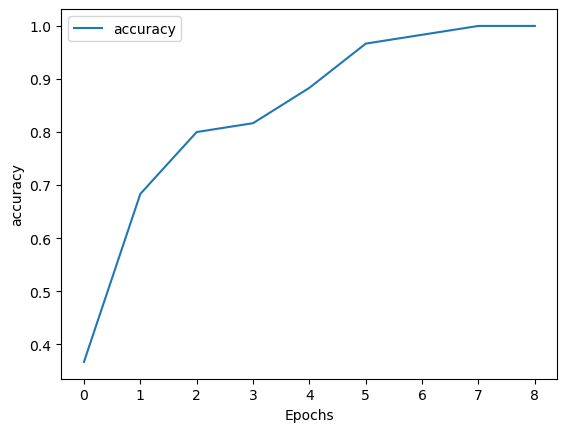

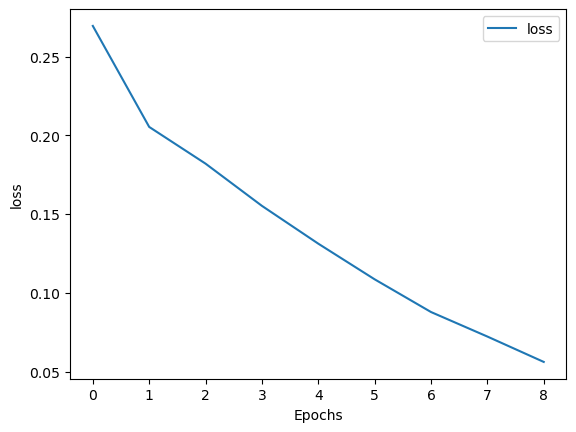

In [25]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [26]:
model.save('../saved_models/araucaria_model_bin')

INFO:tensorflow:Assets written to: ../saved_models/araucaria_model_bin/assets


INFO:tensorflow:Assets written to: ../saved_models/araucaria_model_bin/assets
